In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, StratifiedShuffleSplit, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.externals import joblib

In [47]:
labels = pd.read_csv("targets 28.02.2018.csv", sep=";")
labels

,patient_number,target,E/no E,D/no D,E/C,TLE/no E,TLE/C,D/C,DE/E,MRIPositive/Negative,TLEPositive/C,TLENegative/C,NoTLE/C
0,P001,E,E,ND,E,TLE,TLE,-666.0,E,Negative,-666,TLENegative,-666
1,P002,DE,E,D,-666,-666,-666,-666.0,DE,Negative,-666,-666,NoTLE
2,P003,E,E,ND,E,TLE,TLE,-666.0,E,Positive,TLEPositive,-666,-666
3,P004,D,NE,D,-666,NE,-666,D,-666,Negative,-666,-666,-666
4,P006,E,E,ND,E,-666,-666,-666,E,Negative,-666,-666,NoTLE
5,P008,C,NE,ND,C,NE,C,C,-666,Negative,C,C,C
6,P009,E,E,ND,E,-666,-666,-666,E,Negative,-666,-666,NoTLE
7,P010,E,E,ND,E,-666,-666,-666,E,Negative,-666,-666,NoTLE
8,P011,E,E,ND,E,TLE,TLE,-666,E,Negative,-666,TLENegative,-666
9,P012,D,NE,D,-666,NE,-666,D,-666,Positive,-666,-666,-666


### Загрузка данных

In [48]:
mri_data = pd.read_csv("T1 morphometry merged 27.02.2018.csv", index_col=0)

labels = pd.read_csv("targets 28.02.2018.csv", sep=";")

idx_to_label = ["C", "D", "E", "DE", "NE", "ND", "TLE", "Positive", "Negative", "TLEPositive", "TLENegative", "NoTLE"]
label_to_idx = {l : i for i, l in enumerate(idx_to_label)}

for col in labels.columns[1:]:
    labels[col] = labels[col].apply(lambda x: label_to_idx[x] if x in label_to_idx else np.nan)
    
E_C_idx = labels["E/C"].notnull()
TLE_noE_idx = labels["TLE/no E"].notnull()
TLE_C_idx = labels["TLE/C"].notnull()
D_C_idx = labels["D/C"].notnull()
DE_E_idx = labels["DE/E"].notnull()
Pos_Neg_idx = labels["MRIPositive/Negative "].notnull()
TLEPos_C_idx = labels["TLEPositive/C"].notnull()
TLENeg_C_idx = labels["TLENegative/C"].notnull()
NoTLE_C_idx = labels["NoTLE/C"].notnull()

In [49]:
mri_data.head()

,bankssts_NumVert_r,caudalanteriorcingulate_NumVert_r,caudalmiddlefrontal_NumVert_r,cuneus_NumVert_r,entorhinal_NumVert_r,fusiform_NumVert_r,inferiorparietal_NumVert_r,inferiortemporal_NumVert_r,isthmuscingulate_NumVert_r,lateraloccipital_NumVert_r,...,Right-vessel_normRange,Right-choroid-plexus_normRange,5th-Ventricle_normRange,WM-hypointensities_normRange,non-WM-hypointensities_normRange,Optic-Chiasm_normRange,CC_Posterior_normRange,CC_Mid_Posterior_normRange,CC_Central_normRange,CC_Mid_Anterior_normRange
0,1247,986,3896,2867,828,4919,9874,5581,1394,9770,...,0.0,67.0,0.0,88.0,0.0,86.0,79.0,105.0,77.0,73.0
1,1387,1814,4320,2712,563,6257,11170,7654,1768,10924,...,30.0,63.0,0.0,82.0,0.0,94.0,78.0,108.0,97.0,90.0
2,1368,936,5289,2636,382,4608,7697,6417,1703,10003,...,36.0,68.0,0.0,120.0,0.0,83.0,94.0,95.0,97.0,81.0
3,1924,1149,2857,2739,655,4329,8762,5285,1535,9430,...,17.0,69.0,0.0,89.0,0.0,90.0,79.0,96.0,94.0,119.0
4,1148,976,3864,2823,509,4835,8748,5685,1462,8483,...,80.0,66.0,0.0,74.0,0.0,110.0,71.0,76.0,85.0,77.0


In [50]:
labels.head()

,patient_number,target,E/no E,D/no D,E/C,TLE/no E,TLE/C,D/C,DE/E,MRIPositive/Negative,TLEPositive/C,TLENegative/C,NoTLE/C
0,P001,2,2,5,2.0,6.0,6.0,NaN,2.0,8,NaN,10.0,NaN
1,P002,3,2,1,NaN,NaN,NaN,NaN,3.0,8,NaN,NaN,11.0
2,P003,2,2,5,2.0,6.0,6.0,NaN,2.0,7,9.0,NaN,NaN
3,P004,1,4,1,NaN,4.0,NaN,1.0,NaN,8,NaN,NaN,NaN
4,P006,2,2,5,2.0,NaN,NaN,NaN,2.0,8,NaN,NaN,11.0


In [6]:
# отбор признаков на основе модели
# аналогично SelectFromModel, но на основе количества признаков, а не порога

from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone
from sklearn.feature_selection.base import SelectorMixin
from sklearn.feature_selection.from_model import _get_feature_importances
from sklearn.utils.metaestimators import if_delegate_has_method

class SelectNFeaturesFromModel(BaseEstimator, SelectorMixin, MetaEstimatorMixin):
    def __init__(self, estimator, n_selected, prefit=False):
        self.estimator = estimator
        self.n_selected = n_selected
        self.prefit = prefit

    def _get_support_mask(self):
        if self.prefit:
            estimator = self.estimator
        elif hasattr(self, 'estimator_'):
            estimator = self.estimator_
        else:
            raise ValueError(
                'Either fit SelectFromModel before transform or set "prefit='
                'True" and pass a fitted estimator to the constructor.')
        scores = _get_feature_importances(estimator)
        threshold = np.sort(scores)[-self.n_selected]
        return scores >= threshold

    def fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(X, y, **fit_params)
        return self

    @property
    def threshold_(self):
        scores = _get_feature_importances(self.estimator_, self.norm_order)
        return np.sort(scores)[-n_selected]
    
    @if_delegate_has_method('estimator')
    def partial_fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        if not hasattr(self, "estimator_"):
            self.estimator_ = clone(self.estimator)
        self.estimator_.partial_fit(X, y, **fit_params)
        return self

In [7]:
def get_svc_grid(cv, dim_reduction_methods, random_state=None,
                 svc_kernel_l=None, svc_c_l=None, svc_gamma_l=None):

    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', SVC(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if svc_kernel_l is not None:
        param_grid['classifier__kernel'] = svc_kernel_l
    if svc_c_l is not None:
        param_grid['classifier__C'] = svc_c_l
    if svc_gamma_l is not None:
        param_grid['classifier__gamma'] = svc_gamma_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [8]:
def get_lr_grid(cv, dim_reduction_methods, random_state=None,
                 lr_c_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', LogisticRegression(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if lr_c_l is not None:
        param_grid['classifier__C'] = lr_c_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [9]:
def get_rfc_grid(cv, dim_reduction_methods, random_state=None,
                 rfc_n_estimators_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', RandomForestClassifier(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if rfc_n_estimators_l is not None:
        param_grid['classifier__n_estimators'] = rfc_n_estimators_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [10]:
def get_knn_grid(cv, dim_reduction_methods, random_state=None,
                 knn_n_neighbors_l=None, knn_weights_l=None, knn_p_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', KNeighborsClassifier()),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if knn_n_neighbors_l is not None:
        param_grid['classifier__n_neighbors'] = knn_n_neighbors_l
    if knn_weights_l is not None:
        param_grid['classifier__weights'] = knn_weights_l
    if knn_p_l is not None:
        param_grid['classifier__p'] = knn_p_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [11]:
# set printoptions
pd.set_option('expand_frame_repr', True)
pd.set_option('max_colwidth', 150)

In [12]:
def print_results(clf_grid_dict):
    results = {
            "classifier" : [], 
            "best parameters" : [],
            "best dim. reduction method" : [],
            "mean" : [],
            "std" : []
           }
    
    for clf, grid in clf_grid_dict.items():
        results["classifier"].append(clf)
        results["best parameters"].append(", ".join(
            [param + " = " + str(best_value) for param, best_value in grid.best_params_.items() if param != 'dim_reduction']))
        results["best dim. reduction method"].append(grid.best_params_['dim_reduction'])
        idx = grid.best_index_
        results["mean"].append(grid.cv_results_['mean_test_score'][idx])
        results["std"].append(grid.cv_results_['std_test_score'][idx])
        
    results = pd.DataFrame(results, columns=["classifier", "best parameters", "best dim. reduction method", "mean", "std"])
    display(results.set_index("classifier"))
    
    # draw graph
    width = 0.9
    for i in results.index:
        plt.bar(i, results.loc[i, "mean"], width, yerr=results.loc[i, "std"], label=results.loc[i, "classifier"])
    plt.xticks(range(results.shape[0]), results.loc[:, "classifier"])
    plt.axis(ymin=0.0, ymax=1.0)
    plt.show()
    
    print("Best model: ")
    clf = results.loc[results["mean"].argmax(), "classifier"]
    print(clf)
    print("\n".join(
            [param + " = " + str(best_value) for param, best_value in clf_grid_dict[clf].best_params_.items()]))
    print()
    print("mean =", results["mean"].max())
    print("std =", results.loc[results["mean"].argmax(), "std"])

### Объединенный подсчет и сравнение всех классификаторов (SVC, LR, RFC, KNN)

In [23]:
def train_grid_cv(X, y, n_splits, n_repeats, random_state=None):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    
    n_features = [5, 10, 20, 50, 100]
    n_components = [2, 3, 5, 10, 15, 20]
    
    # list of dimensionality reduction methods
    dim_reduction_methods = []
    dim_reduction_methods += [SelectKBest(stats.ttest_ind, n) for n in n_features]
    dim_reduction_methods += [SelectKBest(f_classif, n) for n in n_features]
    dim_reduction_methods += [SelectNFeaturesFromModel(RandomForestClassifier(n_estimators=100, random_state=random_state), n) for n in n_features]
    dim_reduction_methods += [SelectNFeaturesFromModel(LogisticRegression(), n) for n in n_features]
    dim_reduction_methods += [SelectNFeaturesFromModel(ExtraTreesClassifier(n_estimators=100, random_state=random_state), n) for n in n_features]
    dim_reduction_methods += [PCA(n) for n in n_components]
    dim_reduction_methods += [LocallyLinearEmbedding(n_components=n, random_state=random_state) for n in n_components]
    
    
    print("Training SVC...")
    grid_cv_svc = get_svc_grid(cv, dim_reduction_methods, random_state=random_state,
                               svc_kernel_l=["rbf", "linear"],
                               svc_c_l=[10 ** i for i in range(-6, 4, 2)],
                               svc_gamma_l=[10 ** i for i in range(-6, 2, 2)])
    start_time = time.time()
    grid_cv_svc.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training LR...")
    grid_cv_lr = get_lr_grid(cv, dim_reduction_methods, random_state=random_state,
                             lr_c_l=[10 ** i for i in range(-6, 2, 2)])
    start_time = time.time()
    grid_cv_lr.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training RFC...")
    grid_cv_rfc = get_rfc_grid(cv, dim_reduction_methods, random_state=random_state,
                               rfc_n_estimators_l=[i for i in range(300, 950, 150)])
    start_time = time.time()
    grid_cv_rfc.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training KNN...")
    class_size_tr = min(y.value_counts())
    grid_cv_knn = get_knn_grid(cv, dim_reduction_methods, random_state=random_state,
                              knn_p_l=[1, 2],
                              knn_weights_l=["uniform", "distance"],
                              knn_n_neighbors_l=[i for i in range(5, class_size_tr - 1, 2)])
    start_time = time.time()
    grid_cv_knn.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print_results({
        "SVC" : grid_cv_svc,
        "LR" : grid_cv_lr,
        "RFC" : grid_cv_rfc,
        "KNN" : grid_cv_knn
                  })
    
    best_model = max([grid_cv_svc, grid_cv_lr, grid_cv_rfc, grid_cv_knn], key=lambda x: x.best_score_).best_estimator_
    
    return best_model, grid_cv_svc, grid_cv_lr, grid_cv_rfc, grid_cv_knn

In [14]:
n_objects = mri_data.shape[0]

def repeated_cross_val_predict(estimator, X, y, cv, file=None):
    predictions = [[] for i in range(n_objects)]
    for idx_tr, idx_te in tqdm(cv.split(X, y)):
        estimator.fit(X.iloc[idx_tr], y.iloc[idx_tr])
        pred_te = np.array(estimator.predict(X.iloc[idx_te]), dtype=int)
        for i, idx in enumerate(idx_te):
            predictions[X.index[idx]].append(idx_to_label[pred_te[i]])
        
    predictions = pd.DataFrame(predictions)
    if file is not None:
        predictions.to_csv(file)
        
    return predictions

In [15]:
def save_model(model, file):
    joblib.dump(model, file)
    
def load_model(file):
    model = joblib.load(file)
    return model

### Training

In [51]:
labels.head()

,patient_number,target,E/no E,D/no D,E/C,TLE/no E,TLE/C,D/C,DE/E,MRIPositive/Negative,TLEPositive/C,TLENegative/C,NoTLE/C
0,P001,2,2,5,2.0,6.0,6.0,NaN,2.0,8,NaN,10.0,NaN
1,P002,3,2,1,NaN,NaN,NaN,NaN,3.0,8,NaN,NaN,11.0
2,P003,2,2,5,2.0,6.0,6.0,NaN,2.0,7,9.0,NaN,NaN
3,P004,1,4,1,NaN,4.0,NaN,1.0,NaN,8,NaN,NaN,NaN
4,P006,2,2,5,2.0,NaN,NaN,NaN,2.0,8,NaN,NaN,11.0


dataset: MRI T1
1. 4 classes
2. Epilepsy / no epilepsy
3. Depression / no depression
4. Epilepsy / control
5. Depression / control
6. Epilepsy with depression / only epilepsy
7. TLE / no epilepsy
8. TLE / control
9. MRI positive / MRI negative epilepsy
10. TLE positive / control
11. TLE negative / control
12. Not TLE epilepsy / control

### 1. 4 classes

In [ ]:
n_splits = 5
X, y = mri_data, labels.target

best_model_mri_DE, grid_cv_svc_mri_DE, grid_cv_lr_mri_DE, grid_cv_rfc_mri_DE, grid_cv_knn_mri_DE = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_DE = repeated_cross_val_predict(best_model_mri_DE, X, y, cv, file="labels_mri_4_classes.csv")

save_model(best_model_mri_DE, "best_model_mri_4_classes.pkl")

### 2. Epilepsy / no epilepsy

In [ ]:
n_splits = 10
X, y = mri_data, labels["E/no E"]

best_model_mri_E, grid_cv_svc_mri_E, grid_cv_lr_mri_E, grid_cv_rfc_mri_E, grid_cv_knn_mri_E = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_E = repeated_cross_val_predict(best_model_mri_E, X, y, cv, file="labels_mri_E_noE.csv")

save_model(best_model_mri_E, "best_model_mri_E_noE.pkl")

### 3. Depression / no depression

In [26]:
n_splits = 10
X, y = mri_data, labels["D/no D"]

best_model_mri_D, grid_cv_svc_mri_D, grid_cv_lr_mri_D, grid_cv_rfc_mri_D, grid_cv_knn_mri_D = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_D = repeated_cross_val_predict(best_model_mri_D, X, y, cv, file="labels_mri_D_noD.csv")

save_model(best_model_mri_D, "best_model_mri_D_noD.pkl")

### 4. Epilepsy / control

In [ ]:
n_splits = 5
X, y = mri_data[E_C_idx], labels[E_C_idx]["E/C"]

best_model_mri_E_C, grid_cv_svc_mri_E_C, grid_cv_lr_mri_E_C, grid_cv_rfc_mri_E_C, grid_cv_knn_mri_E_C = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_E_C = repeated_cross_val_predict(best_model_mri_E_C, X, y, cv, file="labels_mri_E_C.csv")

save_model(best_model_mri_E_C, "best_model_mri_E_C.pkl")

### 5. Depression / control

In [ ]:
n_splits = 5
X, y = mri_data[D_C_idx], labels[D_C_idx]["D/C"]

best_model_mri_D_C, grid_cv_svc_mri_D_C, grid_cv_lr_mri_D_C, grid_cv_rfc_mri_D_C, grid_cv_knn_mri_D_C = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_D_C = repeated_cross_val_predict(best_model_mri_D_C, X, y, cv, file="labels_mri_D_C.csv")

save_model(best_model_mri_D_C, "best_model_mri_D_C.pkl")

### 6. Epilepsy with depression / only epilepsy

In [19]:
n_splits = 5
X, y = mri_data[DE_E_idx], labels[DE_E_idx]["DE/E"]

best_model_mri_DE_E, grid_cv_svc_mri_DE_E, grid_cv_lr_mri_DE_E, grid_cv_rfc_mri_DE_E, grid_cv_knn_mri_DE_E = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_DE_E = repeated_cross_val_predict(best_model_mri_DE_E, X, y, cv, file="labels_mri_DE_E.csv")

save_model(best_model_mri_DE_E, "best_model_mri_DE_E.pkl")

### 7. TLE / no epilepsy

Training SVC...
(training took 4047.0469088554382s)

Training LR...
(training took 336.8346230983734s)

Training RFC...
(training took 4975.22954750061s)

Training KNN...
(training took 5008.947035312653s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
KNN,"classifier__weights = uniform, classifier__p = 2, classifier__n_neighbors = 5","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.7200,0.066427
LR,classifier__C = 1,"SelectKBest(k=100, score_func=<function f_classif at 0x7f192450dc80>)",0.7475,0.119216
RFC,classifier__n_estimators = 900,"SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.7700,0.076485
SVC,"classifier__C = 100, classifier__gamma = 0.01, classifier__kernel = rbf","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.7850,0.122577


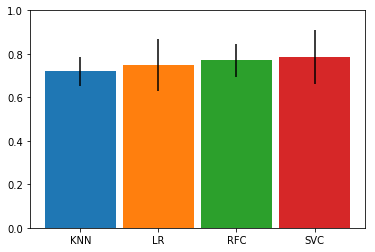

2it [00:00, 13.46it/s]

Best model: 
SVC
classifier__C = 100
classifier__gamma = 0.01
classifier__kernel = rbf
dim_reduction = SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             n_selected=20, prefit=False)

mean = 0.785
std = 0.122576506721


50it [00:03, 15.48it/s]


In [21]:
n_splits = 5 # ?
X, y = mri_data[TLE_noE_idx], labels[TLE_noE_idx]["TLE/no E"]

best_model_mri_TLE_noE, grid_cv_svc_mri_TLE_noE, grid_cv_lr_mri_TLE_noE, grid_cv_rfc_mri_TLE_noE, grid_cv_knn_mri_TLE = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_TLE_noE = repeated_cross_val_predict(best_model_mri_TLE_noE, X, y, cv, file="labels_mri_TLE_noE.csv")

save_model(best_model_mri_TLE_noE, "best_model_mri_TLE_noE.pkl")

In [36]:
# imbalaced classification scoring
n_splits = 5 # ? 
X, y = mri_data[TLE_noE_idx], labels[TLE_noE_idx]["TLE/no E"]
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
scores = cross_val_score(best_model_mri_TLE_noE, X, (y == 4), scoring="roc_auc", cv=cv)
print("mean = ", scores.mean())
print("std = ", scores.std())

mean =  0.784
std =  0.122245654319


In [17]:
labels[TLE_noE_idx]["TLE/no E"].value_counts()

4.0    50
6.0    30
Name: TLE/no E, dtype: int64

### 8. TLE / control

Training SVC...
(training took 3299.90358376503s)

Training LR...
(training took 291.3265781402588s)

Training RFC...
(training took 4702.332923412323s)

Training KNN...
(training took 2619.2746181488037s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
KNN,"classifier__weights = distance, classifier__p = 1, classifier__n_neighbors = 7","SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',\n max_depth=None, max_feat...",0.687273,0.128770
LR,classifier__C = 1,"PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.749091,0.146090
RFC,classifier__n_estimators = 600,"SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.705455,0.146090
SVC,"classifier__C = 100, classifier__gamma = 0.01, classifier__kernel = rbf","SelectKBest(k=100, score_func=<function f_classif at 0x7f192450dc80>)",0.756364,0.140177


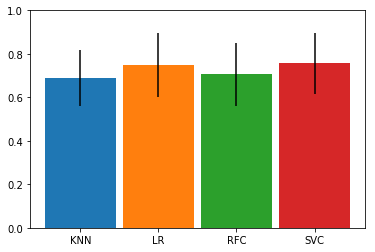

3it [00:00, 22.66it/s]

Best model: 
SVC
classifier__C = 100
classifier__gamma = 0.01
classifier__kernel = rbf
dim_reduction = SelectKBest(k=100, score_func=<function f_classif at 0x7f192450dc80>)

mean = 0.756363636364
std = 0.140176983763


50it [00:01, 30.53it/s]


In [22]:
n_splits = 5 # ?
X, y = mri_data[TLE_C_idx], labels[TLE_C_idx]["TLE/C"]

best_model_mri_TLE_C, grid_cv_svc_mri_TLE_C, grid_cv_lr_mri_TLE_C, grid_cv_rfc_mri_TLE_C, grid_cv_knn_mri_TLE_C = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_TLE_C = repeated_cross_val_predict(best_model_mri_TLE_C, X, y, cv, file="labels_mri_TLE_C.csv")

save_model(best_model_mri_TLE_C, "best_model_mri_TLE_C.pkl")

In [38]:
# imbalaced classification scoring
n_splits = 5 # ? 
X, y = mri_data[TLE_C_idx], labels[TLE_C_idx]["TLE/C"]
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
scores = cross_val_score(best_model_mri_TLE_C, X, (y == 6), scoring="roc_auc", cv=cv)
print("mean = ", scores.mean())
print("std = ", scores.std())

mean =  0.803333333333
std =  0.1456403485


In [18]:
labels[TLE_C_idx]["TLE/C"].value_counts()

6.0    30
0.0    25
Name: TLE/C, dtype: int64

### 9. MRI positive / MRI negative

Training SVC...
(training took 5862.368365287781s)

Training LR...
(training took 394.96374583244324s)

Training RFC...
(training took 6374.472034215927s)

Training KNN...
(training took 3528.19188952446s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
KNN,"classifier__weights = distance, classifier__p = 2, classifier__n_neighbors = 7","PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.824,0.060511
LR,classifier__C = 1,"SelectKBest(k=5, score_func=<function ttest_ind at 0x7f1924f4d7b8>)",0.814,0.036614
RFC,classifier__n_estimators = 450,"SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.822,0.052427
SVC,"classifier__C = 1, classifier__gamma = 0.01, classifier__kernel = linear","PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.828,0.059404


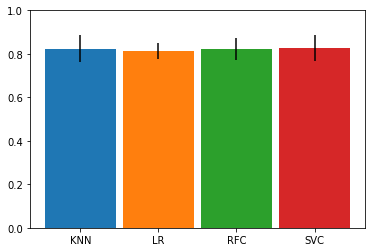

1it [00:00,  9.98it/s]

Best model: 
SVC
classifier__C = 1
classifier__gamma = 0.01
classifier__kernel = linear
dim_reduction = PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

mean = 0.828
std = 0.0594035517026


50it [00:03, 12.73it/s]


In [26]:
n_splits = 5 # ? 
X, y = mri_data[Pos_Neg_idx], labels[Pos_Neg_idx]["MRIPositive/Negative "]

best_model_mri_Pos_Neg, grid_cv_svc_mri_Pos_Neg, grid_cv_lr_mri_Pos_Neg, grid_cv_rfc_mri_Pos_Neg, grid_cv_knn_mri_Pos_Neg = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_Pos_Neg = repeated_cross_val_predict(best_model_mri_Pos_Neg, X, y, cv, file="labels_mri_Pos_Neg.csv")

save_model(best_model_mri_Pos_Neg, "best_model_mri_Pos_Neg.pkl")

In [35]:
# imbalaced classification scoring
n_splits = 5 # ? 
X, y = mri_data[Pos_Neg_idx], labels[Pos_Neg_idx]["MRIPositive/Negative "]
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
scores = cross_val_score(best_model_mri_Pos_Neg, X, (y == 8), scoring="roc_auc", cv=cv)
print("mean = ", scores.mean())
print("std = ", scores.std())

mean =  0.723504901961
std =  0.176601771605


In [19]:
labels[Pos_Neg_idx]["MRIPositive/Negative "].value_counts()

8    81
7    19
Name: MRIPositive/Negative , dtype: int64

### 10. TLE positive / control

Training SVC...
(training took 3196.5003509521484s)

Training LR...
(training took 338.5875315666199s)

Training RFC...
(training took 6513.391249656677s)

Training KNN...
(training took 1909.3484466075897s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
KNN,"classifier__weights = distance, classifier__p = 1, classifier__n_neighbors = 5","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.755,0.090000
LR,classifier__C = 0.01,"SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.775,0.117260
RFC,classifier__n_estimators = 300,"SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.805,0.100499
SVC,"classifier__C = 100, classifier__gamma = 0.0001, classifier__kernel = rbf","PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.810,0.112472


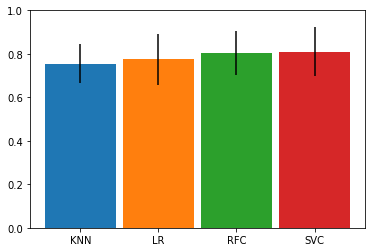

2it [00:00, 14.49it/s]

Best model: 
SVC
classifier__C = 100
classifier__gamma = 0.0001
classifier__kernel = rbf
dim_reduction = PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

mean = 0.81
std = 0.112472218792


50it [00:05,  9.66it/s]


In [25]:
n_splits = 5 # ?
X, y = mri_data[TLEPos_C_idx], labels[TLEPos_C_idx]["TLEPositive/C"]

best_model_mri_TLEPos_C, grid_cv_svc_mri_TLEPos_C, grid_cv_lr_mri_TLEPos_C, grid_cv_rfc_mri_TLEPos_C, grid_cv_knn_mri_TLEPos_C = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_TLEPos_C = repeated_cross_val_predict(best_model_mri_TLEPos_C, X, y, cv, file="labels_mri_TLEPos_C.csv")

save_model(best_model_mri_TLEPos_C, "best_model_mri_TLEPos_C.pkl")

In [34]:
# imbalaced classification scoring
n_splits = 5 # ? 
X, y = mri_data[TLEPos_C_idx], labels[TLEPos_C_idx]["TLEPositive/C"]
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
scores = cross_val_score(best_model_mri_TLEPos_C, X, (y == 9), scoring="roc_auc", cv=cv)
print("mean = ", scores.mean())
print("std = ", scores.std())

mean =  0.84
std =  0.139841179756


In [46]:
labels[TLEPos_C_idx]["TLEPositive/C"].value_counts()

0.0    25
9.0    15
Name: TLEPositive/C, dtype: int64

### 11. TLE negative / control

Training SVC...
(training took 2616.644658088684s)

Training LR...
(training took 250.9195373058319s)

Training RFC...
(training took 4660.015121936798s)

Training KNN...
(training took 1324.8282334804535s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
KNN,"classifier__weights = uniform, classifier__p = 1, classifier__n_neighbors = 5","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.780,0.107703
LR,classifier__C = 1,"SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.865,0.116833
RFC,classifier__n_estimators = 450,"SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.795,0.121861
SVC,"classifier__C = 1, classifier__gamma = 0.01, classifier__kernel = rbf","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.850,0.122474


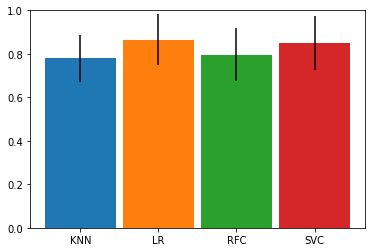

6it [00:00, 58.00it/s]

Best model: 
LR
classifier__C = 1
dim_reduction = SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             n_selected=20, prefit=False)

mean = 0.865
std = 0.116833214455


50it [00:00, 77.67it/s]


In [54]:
n_splits = 5 # ?
X, y = mri_data[TLENeg_C_idx], labels[TLENeg_C_idx]["TLENegative/C"]

best_model_mri_TLENeg_C, grid_cv_svc_mri_TLENeg_C, grid_cv_lr_mri_TLENeg_C, grid_cv_rfc_mri_TLENeg_C, grid_cv_knn_mri_TLENeg_C = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_TLENeg_C = repeated_cross_val_predict(best_model_mri_TLENeg_C, X, y, cv, file="labels_mri_TLENeg_C.csv")

save_model(best_model_mri_TLENeg_C, "best_model_mri_TLENeg_C.pkl")

In [55]:
# imbalaced classification scoring
n_splits = 5 # ? 
X, y = mri_data[TLENeg_C_idx], labels[TLENeg_C_idx]["TLENegative/C"]
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
scores = cross_val_score(best_model_mri_TLENeg_C, X, (y == 10), scoring="roc_auc", cv=cv)
print("mean = ", scores.mean())
print("std = ", scores.std())

mean =  0.869333333333
std =  0.139178542407


In [56]:
labels[TLENeg_C_idx]["TLENegative/C"].value_counts()

0.0     25
10.0    15
Name: TLENegative/C, dtype: int64

### 12. Not TLE epilepsy / control

Training SVC...
(training took 3051.8101935386658s)

Training LR...
(training took 276.543918132782s)

Training RFC...
(training took 5465.115428209305s)

Training KNN...
(training took 2712.7564849853516s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
KNN,"classifier__weights = uniform, classifier__p = 1, classifier__n_neighbors = 7","SelectKBest(k=5, score_func=<function ttest_ind at 0x7f1924f4d7b8>)",0.595556,0.121228
LR,classifier__C = 1e-06,"SelectKBest(k=10, score_func=<function ttest_ind at 0x7f1924f4d7b8>)",0.586667,0.164864
RFC,classifier__n_estimators = 300,"SelectKBest(k=5, score_func=<function ttest_ind at 0x7f1924f4d7b8>)",0.640000,0.118759
SVC,"classifier__C = 1, classifier__gamma = 0.01, classifier__kernel = rbf","SelectKBest(k=50, score_func=<function ttest_ind at 0x7f1924f4d7b8>)",0.613333,0.089553


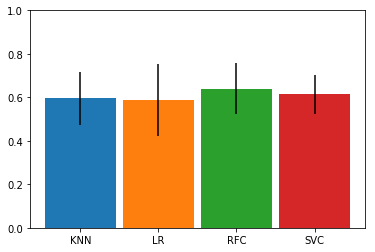

0it [00:00, ?it/s]

Best model: 
RFC
classifier__n_estimators = 300
dim_reduction = SelectKBest(k=5, score_func=<function ttest_ind at 0x7f1924f4d7b8>)

mean = 0.64
std = 0.118759015252


50it [00:40,  1.23it/s]


In [58]:
n_splits = 5 # ?
X, y = mri_data[NoTLE_C_idx], labels[NoTLE_C_idx]["NoTLE/C"]

best_model_mri_NoTLE_C, grid_cv_svc_mri_NoTLE_C, grid_cv_lr_mri_NoTLE_C, grid_cv_rfc_mri_NoTLE_C, grid_cv_knn_mri_NoTLE_C = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_NoTLE_C = repeated_cross_val_predict(best_model_mri_NoTLE_C, X, y, cv, file="labels_mri_NoTLE_C.csv")

save_model(best_model_mri_NoTLE_C, "best_model_mri_NoTLE_C.pkl")

In [59]:
# imbalaced classification scoring
n_splits = 5 # ? 
X, y = mri_data[NoTLE_C_idx], labels[NoTLE_C_idx]["NoTLE/C"]
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
scores = cross_val_score(best_model_mri_NoTLE_C, X, (y == 11), scoring="roc_auc", cv=cv)
print("mean = ", scores.mean())
print("std = ", scores.std())

mean =  0.6835
std =  0.164894663346


In [53]:
labels[NoTLE_C_idx]["NoTLE/C"].value_counts()

0.0     25
11.0    20
Name: NoTLE/C, dtype: int64